In [ ]:
"""
@author: anahí
pip install seaborn
https://scikit-learn.org/stable/modules/tree.html#
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
https://medium.com/@natalia.benitez/%C3%A1rboles-de-decisi%C3%B3n-usando-python-2b0598698944
https://towardsdatascience.com/master-machine-learning-decision-trees-from-scratch-with-python-de75b0494bcd
"""
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import warnings

warnings.filterwarnings('ignore')


In [ ]:
#%%  CARGAMOS DATASET Y LO CONOCEMOS UN POCO
titanic = sns.load_dataset("titanic")

print(titanic.shape)
print(titanic.columns)
titanic.head()


(891, 15)
Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [ ]:
titanic.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
print(f'Hay datos ausentes? {titanic.isnull().any().any()}')
titanic.info()

Hay datos ausentes? True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


survived
0    549
1    342
dtype: int64


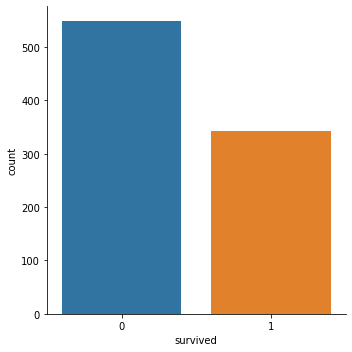

In [ ]:
print(titanic.groupby('survived').size())
sns.catplot('survived', data = titanic, kind = "count")
# 1.5 no, 1 si - » hay desbalance

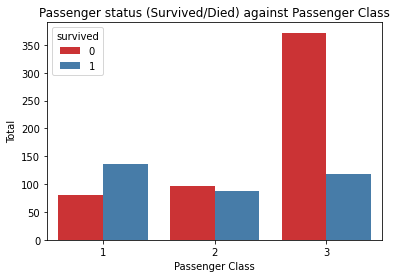

In [ ]:
# https://www.kaggle.com/code/thulani96/titanic-dataset-analysis-with-seaborn

ax = sns.countplot(x = 'pclass', hue = 'survived', palette = 'Set1', data = titanic)
ax.set(title = 'Passenger status (Survived/Died) against Passenger Class', 
       xlabel = 'Passenger Class', ylabel = 'Total')
plt.show()

survived    0    1
sex               
female     81  233
male      468  109


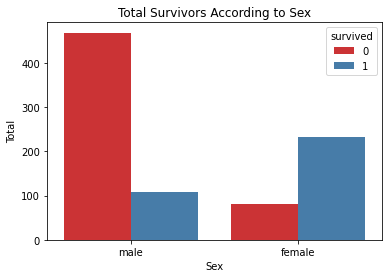

In [ ]:
print(pd.crosstab(titanic["sex"],titanic.survived))
ax = sns.countplot(x = 'sex', hue = 'survived', palette = 'Set1', data = titanic)
ax.set(title = 'Total Survivors According to Sex', xlabel = 'Sex', ylabel='Total')
plt.show()

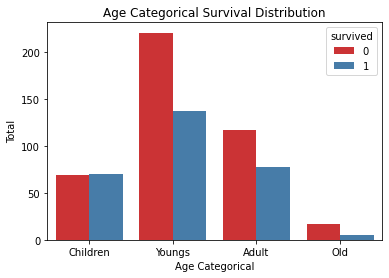

In [ ]:
# We look at Age column and set Intevals on the ages and the map them to their categories as
# (Children, Teen, Adult, Old)
interval = (0,18,35,60,120)
categories = ['Children','Youngs','Adult', 'Old']
titanic['age_cats'] = pd.cut(titanic.age, interval, labels = categories)

ax = sns.countplot(x = 'age_cats',  data = titanic, hue = 'survived', palette = 'Set1')

ax.set(xlabel='Age Categorical', ylabel='Total',
       title="Age Categorical Survival Distribution")

plt.show()


survived    0    1
embarked          
C          75   93
Q          47   30
S         427  217


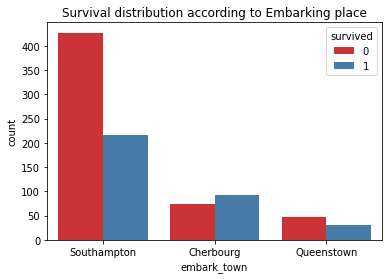

In [ ]:
print(pd.crosstab(titanic['embarked'], titanic.survived))
ax = sns.countplot(x = 'embark_town', hue = 'survived', palette = 'Set1', data = titanic)
ax.set(title = 'Survival distribution according to Embarking place')
plt.show()

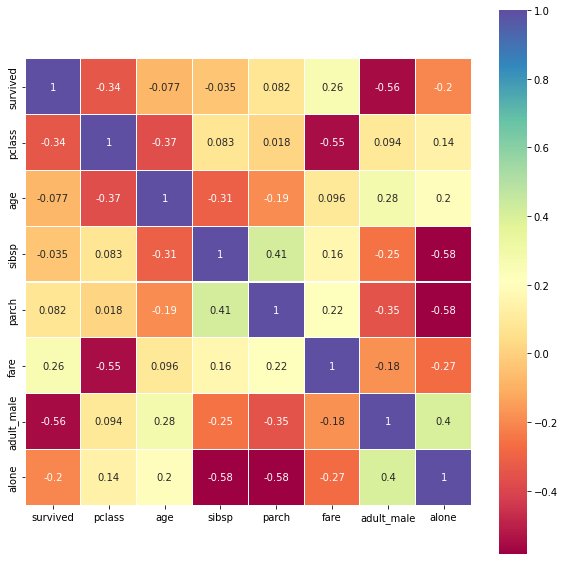

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(titanic.corr(),linewidths=0.1, square=True,  linecolor='white', annot=True, cmap='Spectral')
plt.show()
plt.close()

In [ ]:
#%%  PREPARAMOS LOS DATOS PARA EL MODELO
# eliminamos las filas con 'sex'= NaN
titanic1= titanic.dropna(subset=['age'])
print(titanic1.shape)
titanic1.info()
# quedaron casi todas las columnas sin NaN, excepto 'deck' que sólo tiene 184 valores no nulos
# esa columna la eliminaremos pues no tiene suficientes datos

(714, 15)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     714 non-null    int64   
 1   pclass       714 non-null    int64   
 2   sex          714 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        714 non-null    int64   
 5   parch        714 non-null    int64   
 6   fare         714 non-null    float64 
 7   embarked     712 non-null    object  
 8   class        714 non-null    category
 9   who          714 non-null    object  
 10  adult_male   714 non-null    bool    
 11  deck         184 non-null    category
 12  embark_town  712 non-null    object  
 13  alive        714 non-null    object  
 14  alone        714 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 70.2+ KB


In [ ]:
# definimos la variable a predecir
y = titanic1.pop("survived")

# elegimos las características predictoras
features = ["sex", "class", 'age', 'embark_town', 'adult_male', 'fare', 'pclass']    # columnas para usar
X_not = titanic1[features] 
print(X_not.head())
# aplicamos el método de Pandas equivalente a OneHotEncoder sobre pclass, 
# recordar que sólo opera sobre columnas con type= 'object' o 'category'
# pandas.get_dummies(data, prefix=None, prefix_sep=’_’, dummy_na=False, 
#                    columns=None, sparse=False, drop_first=False, dtype=None)
X=pd.get_dummies(X_not, prefix_sep='-', dummy_na=False, columns=['pclass'])

# aplicamos el Encoder sobre las variables que son 'etiquetables'
le = LabelEncoder()
X['sex'] = le.fit_transform(X['sex'])
X['class'] = le.fit_transform(X['class'])
X['embark_town'] = le.fit_transform(X['embark_town'])
print(X.shape)
X.head()

      sex  class   age  embark_town  adult_male     fare  pclass
0    male  Third  22.0  Southampton        True   7.2500       3
1  female  First  38.0    Cherbourg       False  71.2833       1
2  female  Third  26.0  Southampton       False   7.9250       3
3  female  First  35.0  Southampton       False  53.1000       1
4    male  Third  35.0  Southampton        True   8.0500       3
(714, 9)


,sex,class,age,embark_town,adult_male,fare,pclass-1,pclass-2,pclass-3
0,1,2,22.0,2,True,7.2500,0,0,1
1,0,0,38.0,0,False,71.2833,1,0,0
2,0,2,26.0,2,False,7.9250,0,0,1
3,0,0,35.0,2,False,53.1000,1,0,0
4,1,2,35.0,2,True,8.0500,0,0,1


In [ ]:
print(X_not.head())
print(X.head())

      sex  class   age  embark_town  adult_male     fare  pclass
0    male  Third  22.0  Southampton        True   7.2500       3
1  female  First  38.0    Cherbourg       False  71.2833       1
2  female  Third  26.0  Southampton       False   7.9250       3
3  female  First  35.0  Southampton       False  53.1000       1
4    male  Third  35.0  Southampton        True   8.0500       3
   sex  class   age  embark_town  adult_male     fare  pclass-1  pclass-2  \
0    1      2  22.0            2        True   7.2500         0         0   
1    0      0  38.0            0       False  71.2833         1         0   
2    0      2  26.0            2       False   7.9250         0         0   
3    0      0  35.0            2       False  53.1000         1         0   
4    1      2  35.0            2        True   8.0500         0         0   

   pclass-3  
0         1  
1         0  
2         1  
3         0  
4         1  


In [ ]:
# SEPARAMOS DATASET EN CJTO ENTRENAMIENTO Y TEST 75/25, 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 16, stratify=y)

arbol=DecisionTreeClassifier(criterion='entropy', random_state = 16)
arbol.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=16)

[0.0066417  0.00625592 0.27320167 0.01545536 0.26123413 0.28304678
 0.03941973 0.0064081  0.10833662]


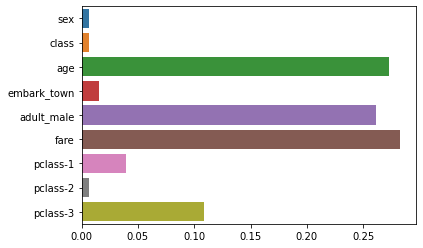

In [ ]:
#%%    VEMOS QUÉ VARIABLES PESARON MÁS EN LAS DECISIONES DEL ÁRBOL
print(arbol.feature_importances_)
sns.barplot(y = X_train.columns, x = arbol.feature_importances_)

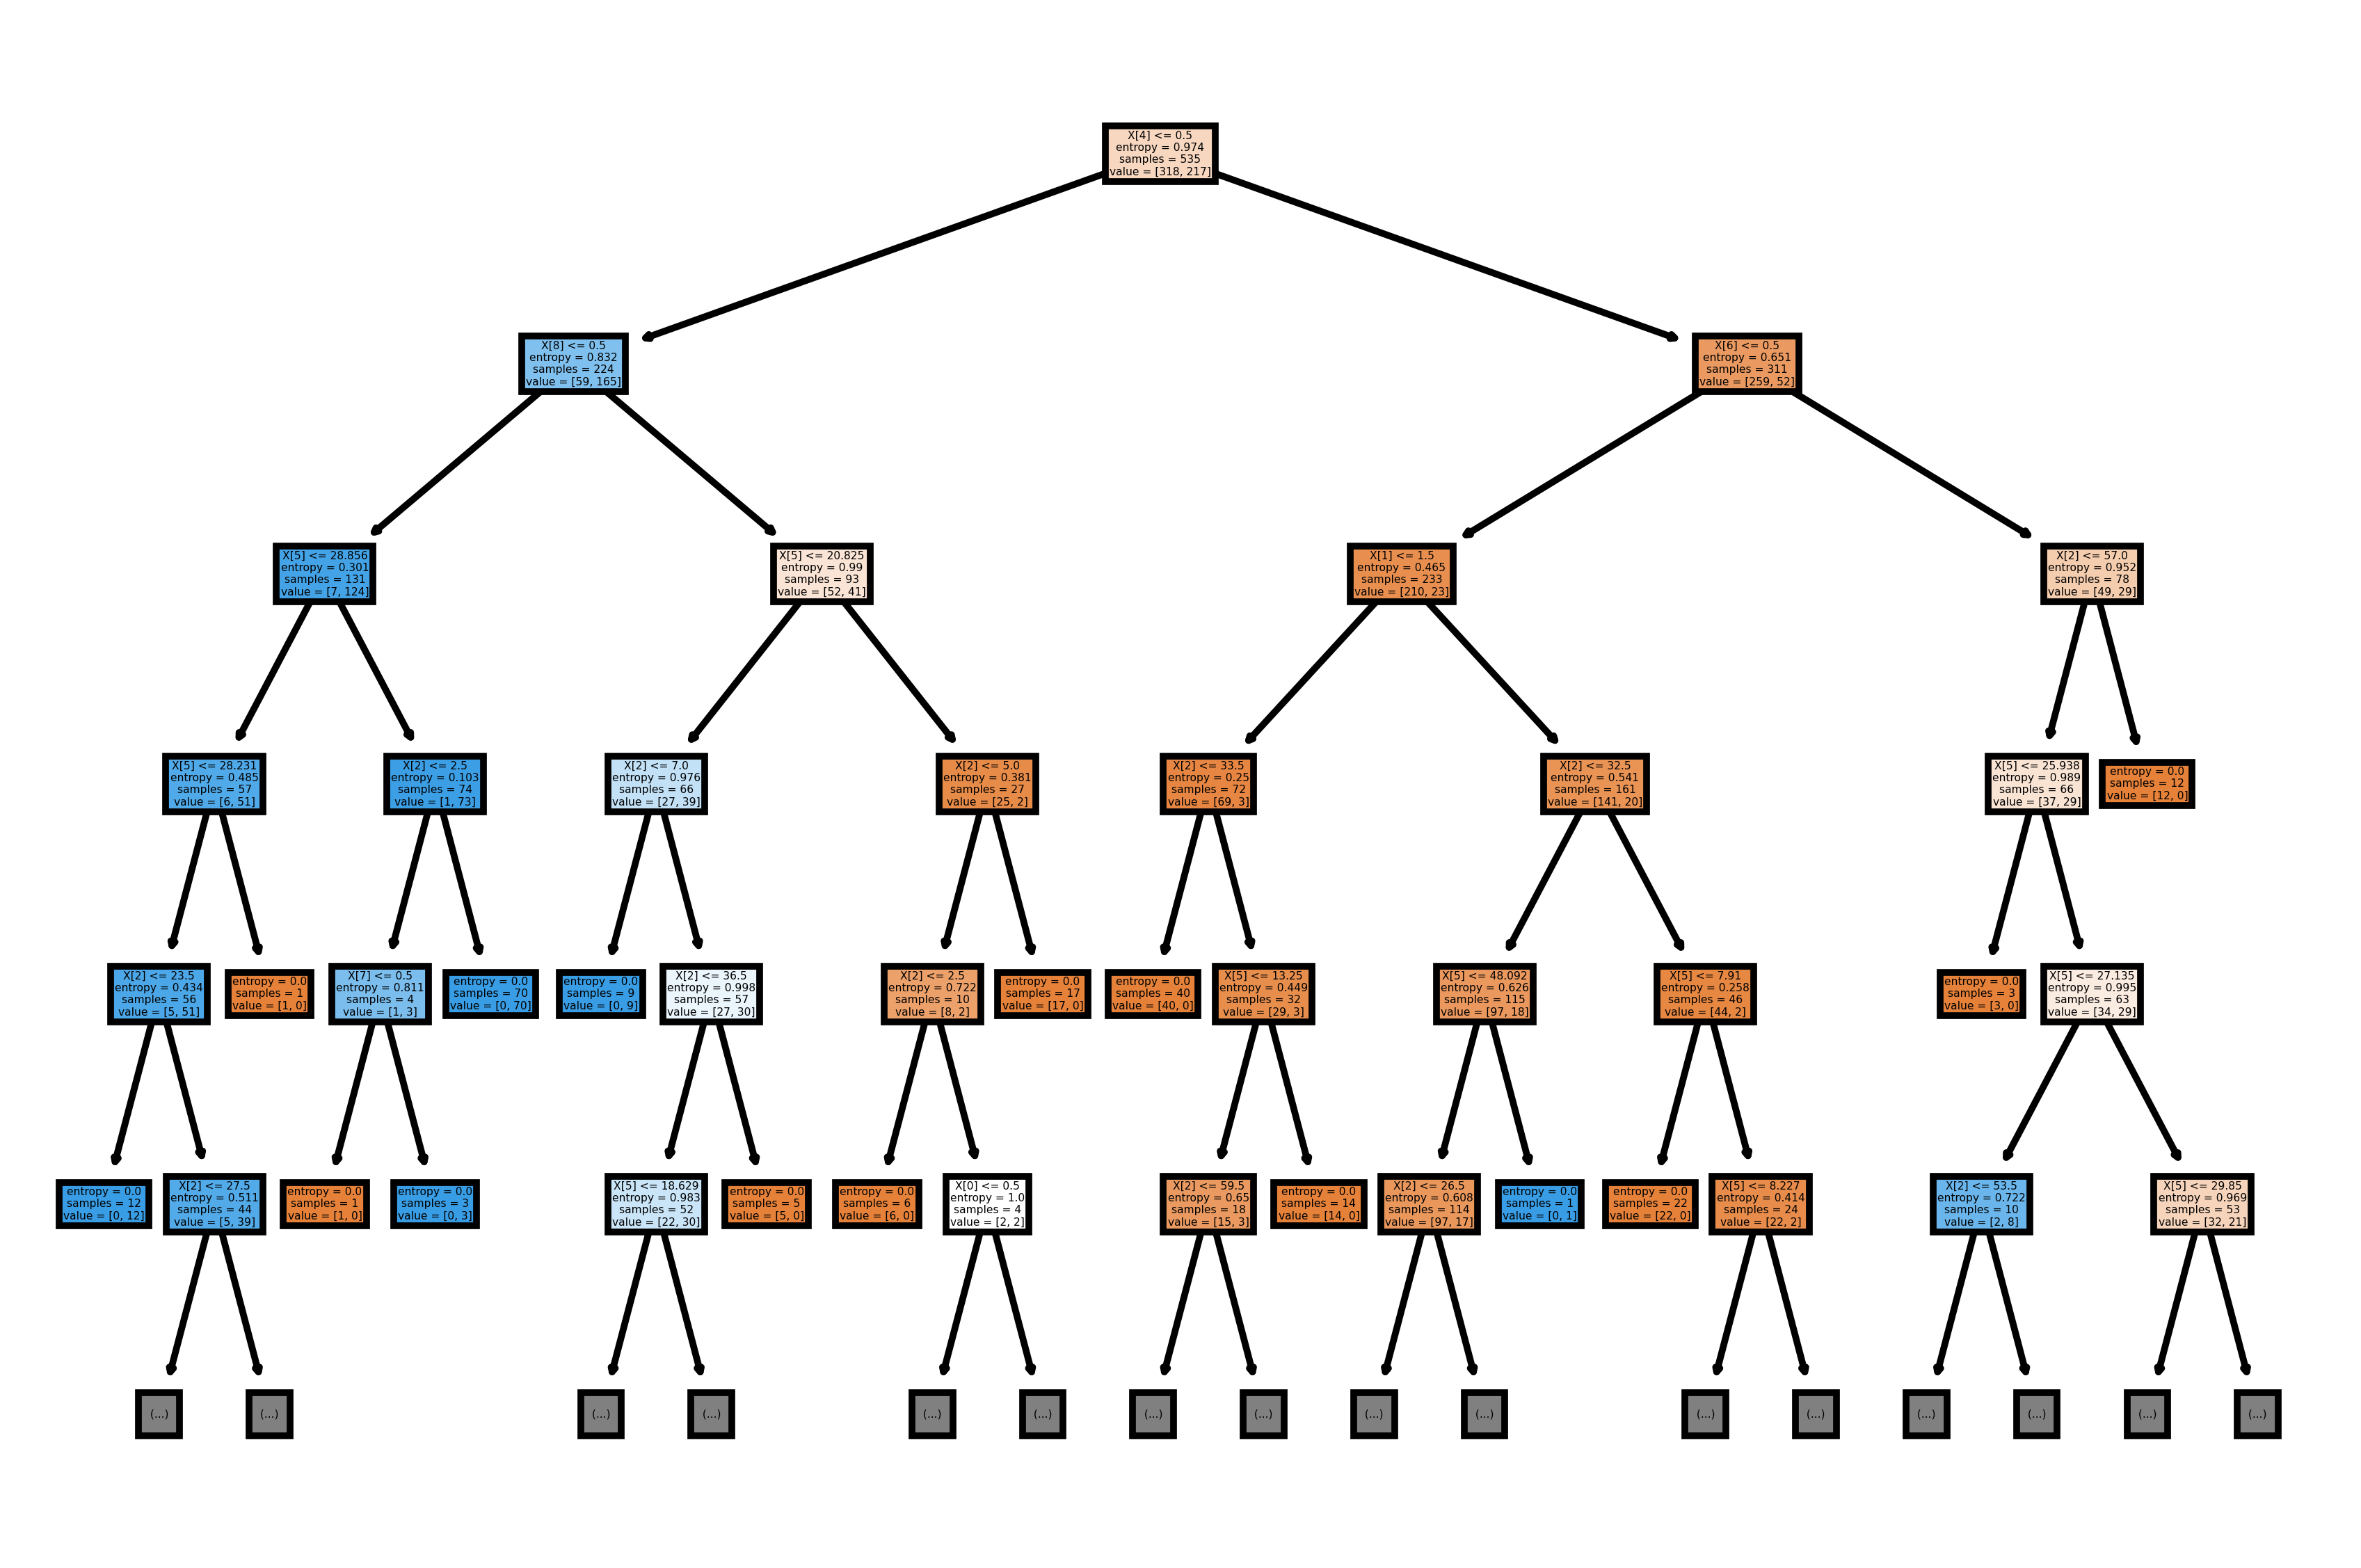

In [ ]:
#%%   GRÁFICO DEL ÁRBOL
# plot_tree(decision_tree, *, max_depth=None, feature_names=None, class_names=None, label='all', filled=False, impurity=True, node_ids=False, proportion=False, rounded=False, precision=3, ax=None, fontsize=None)[source]¶
plt.figure(dpi=700)
plot_tree(arbol, max_depth=5, filled=True)
plt.show()
plt.close()

In [ ]:
#%%    HACEMOS PREDICCIONES Y VEMOS SCORE
y_pred = arbol.predict(X_test)
print('Score train: ', arbol.score(X_train, y_train))
print('Score test:  ', arbol.score(X_test, y_test))

# Se ve claramente que el árbol está sobrejustando

Score train:  0.9869158878504672
Score test:   0.8044692737430168


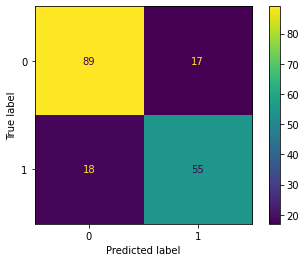

In [ ]:
#%%    MATRIZ DE CONFUSION PARA VER MEJOR EL RENDIMIENTO DEL MODELO
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
#  Y LEO DI CAPRIO? QUÉ DICE EL MODELO QUE LE DEBIÓ SUCEDER?
# features = ["sex", "class", 'age', 'embark_town', 'adult_male', 'fare', 'pclass'] 
leo = {'sex': [1], 'class': [2], 'age': [23], 'embark_town':[2], 'adult_male': [True], 'fare':[7.], 'pclass-3': [1], 'pclass-2':[0], 'pclass-1':[0]}
leo1 = pd.DataFrame.from_dict(leo)
print('Leo sobrevivió? ', arbol.predict(leo1))

# Y Rose? qué fue de ella?
ros = {'sex': [0], 'class': [0], 'age': [21], 'embark_town':[2], 'adult_male': [False], 'fare':[70.], 'pclass-3': [0], 'pclass-2':[0], 'pclass-1':[1]}
rose = pd.DataFrame.from_dict(ros)
print(f'Rose sobrevivió? {arbol.predict(rose)}')


Leo sobrevivió?  [0]
Rose sobrevivió? [0]


In [ ]:
# A ver qué podemos hacer para combatir el sobreajuste...
# Varias estrategias: poner una profundidad máxima, fijar la cantidad de muestras máxima en la hoja y podar
# Veamos la primera
# Preguntamos cuál fue la profundidad máxima del árbol que entrenamos
print(f'Máxima profundidad: {arbol.get_depth()}')    # 20
print(f'Cantidad de hojas: {arbol.get_n_leaves()}')  # 122-126

depth=[i+1 for i in range(20)]
scor_train=[]
scor_test=[]
for dep in depth:
    tree=DecisionTreeClassifier(criterion='gini', max_depth=dep, random_state = 16)
    tree.fit(X_train, y_train)
    pred=tree.predict(X_test)
    print(f'Profundidad: {dep}')
    print(f'Precisión train: {tree.score(X_train, y_train)}')
    print(f'Precisión test: {tree.score(X_test, y_test)}')
    scor_train.append(tree.score(X_train, y_train))
    scor_test.append(tree.score(X_test, y_test))


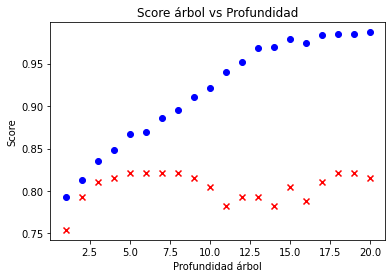

In [ ]:
plt.figure()
plt.scatter(x=depth, y=scor_train, marker='o', color='blue')
plt.scatter(x=depth, y=scor_test, marker='x', color='red')
plt.title('Score árbol vs Profundidad')
plt.xlabel('Profundidad árbol')
plt.ylabel('Score')
plt.show()
plt.close()

In [ ]:
# Otro criterio es regular la cantidad de muestras máxima en cada hoja
samplex=[i+1 for i in range(20)]
scor_train1=[]
scor_test1=[]
for sam in samplex:
    tree=DecisionTreeClassifier(criterion='entropy', min_samples_leaf=sam, random_state = 16)
    tree.fit(X_train, y_train)
    pred=tree.predict(X_test)
    print(f'Profundidad: {sam}')
    print(f'Precisión train: {tree.score(X_train, y_train)}')
    print(f'Precisión test: {tree.score(X_test, y_test)}')
    scor_train1.append(tree.score(X_train, y_train))
    scor_test1.append(tree.score(X_test, y_test))

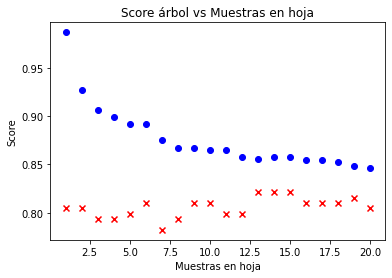

In [ ]:
plt.figure()
plt.scatter(x=samplex, y=scor_train1, marker='o', color='blue')
plt.scatter(x=samplex, y=scor_test1, marker='x', color='red')
plt.title('Score árbol vs Muestras en hoja')
plt.xlabel('Muestras en hoja')
plt.ylabel('Score')
plt.show()
plt.close()

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

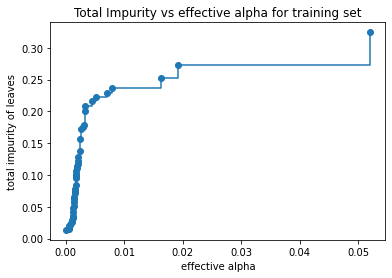

In [ ]:
# Poda posterior
clas = DecisionTreeClassifier(random_state=16)
path = clas.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=16, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.15782388749001836


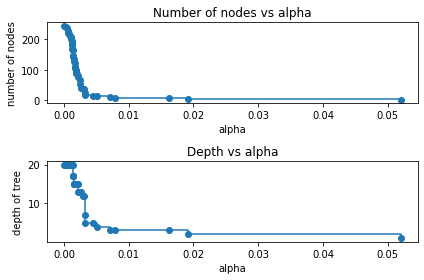

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()


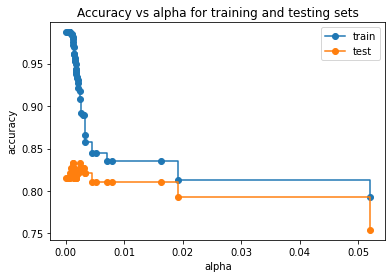

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
print(ccp_alphas)
print(np.array(test_scores))
# el máximo score corresponde a ccp_alpha= 0.0012

[0.         0.00037383 0.00049844 0.00058033 0.00062305 0.00062305
 0.00062305 0.0007269  0.00086782 0.00106809 0.00109034 0.00117281
 0.00119709 0.00124611 0.00126272 0.00135514 0.00140187 0.00140187
 0.00140187 0.00154943 0.00155763 0.00155763 0.0017307  0.00173936
 0.00174232 0.00182357 0.0018439  0.00186916 0.00186916 0.00202971
 0.00210807 0.00213348 0.00252141 0.00252322 0.00270212 0.00299065
 0.00317165 0.0032612  0.00331333 0.00452695 0.0051337  0.00706158
 0.00795974 0.01629123 0.01913396 0.05199677]
[0.81564246 0.81564246 0.81564246 0.81564246 0.81564246 0.81564246
 0.81564246 0.82122905 0.82681564 0.82681564 0.82681564 0.82681564
 0.83240223 0.83240223 0.82681564 0.82681564 0.81564246 0.81564246
 0.81564246 0.81564246 0.81564246 0.81564246 0.81564246 0.81564246
 0.81564246 0.81564246 0.82122905 0.82122905 0.82122905 0.82122905
 0.82122905 0.82122905 0.83240223 0.82681564 0.82681564 0.82681564
 0.82681564 0.82122905 0.82122905 0.81005587 0.81005587 0.81005587
 0.81005587 0.81